In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
# from gridtools.hypnotoad_tools import *
# from gridtools.b2_tools import *
# from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Gridtools not found
Done


# Overview

- here I enable the default flux limiter after realising it was disabled
- It was disabled because I wanted the initial cases to be without limiters
- I didn't realise that the neutral diffusion limiter is physical and required.
- The limiter here is the original Hermes-3 form with the default of 0.2 and 1.0

# Hermes IO

In [2]:
casestore = dict()

In [3]:
db = CaseDB()

toload = [
    # dict(name="1e19", id="d10d-anom_visc", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="2e19", id="d11b-d10d_2e19", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="2e19_free", id="d12a-2e19_free_sol", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="fixTn", id="d13a-d11b_decaylength", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="nolim", id="d14b-edgerec_no_Tnfix", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="lim_0.2", id="d15-d14b_d_fluxlim_default", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="lim_1.0", id="d16-d15_d_fluxlim_1", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="isolim", id="d17-d15_newdmodel_newfluxlim", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.942E+00 [m3]
CHECK: Total domain volume is 1.942E+00 [m3]


In [4]:
plt.close("all")
%matplotlib inline

In [9]:
write_file(casestore, r"C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl")

C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl written


## Read Hermes data

In [5]:
hr = dict()
for hermes_case in casestore.keys():
    print(hermes_case)
    hr[hermes_case] = Hermesdata()
    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

lim_0.2
isolim


# Read SOLEDGE CSV data

In [6]:
soledgecases = {
    "nocurr_base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\nocurrents_baseline"), # Original case with hydrogen
    "nocore_d" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D"), # No ionising core BC, deuterium
    "tightwall" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallMike_bra_nocore_D"),
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata()
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



In [24]:
path = soledgecases["nocore_d"]
sl["nocore_d"].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")

## Read SOLPS

In [7]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0")
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

In [43]:
for name in casestore:

    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds)



# Lineplots

In [ ]:
plt.close("all")
%matplotlib inline

In [ ]:
for casename in casestore.keys():
    print(casename)
    Monitor(casestore[casename], [["avg_density", "avg_temp", "target_temp","radiation"],
                                  ["sep_ne", "sep_te"],
                                  ["cvode_order", "cvode_ncalls_per_second", "cvode_linear_per_newton", "cvode_precon_per_newton", "cvode_fails"]
                ])

In [9]:
plt.close("all")
%matplotlib inline

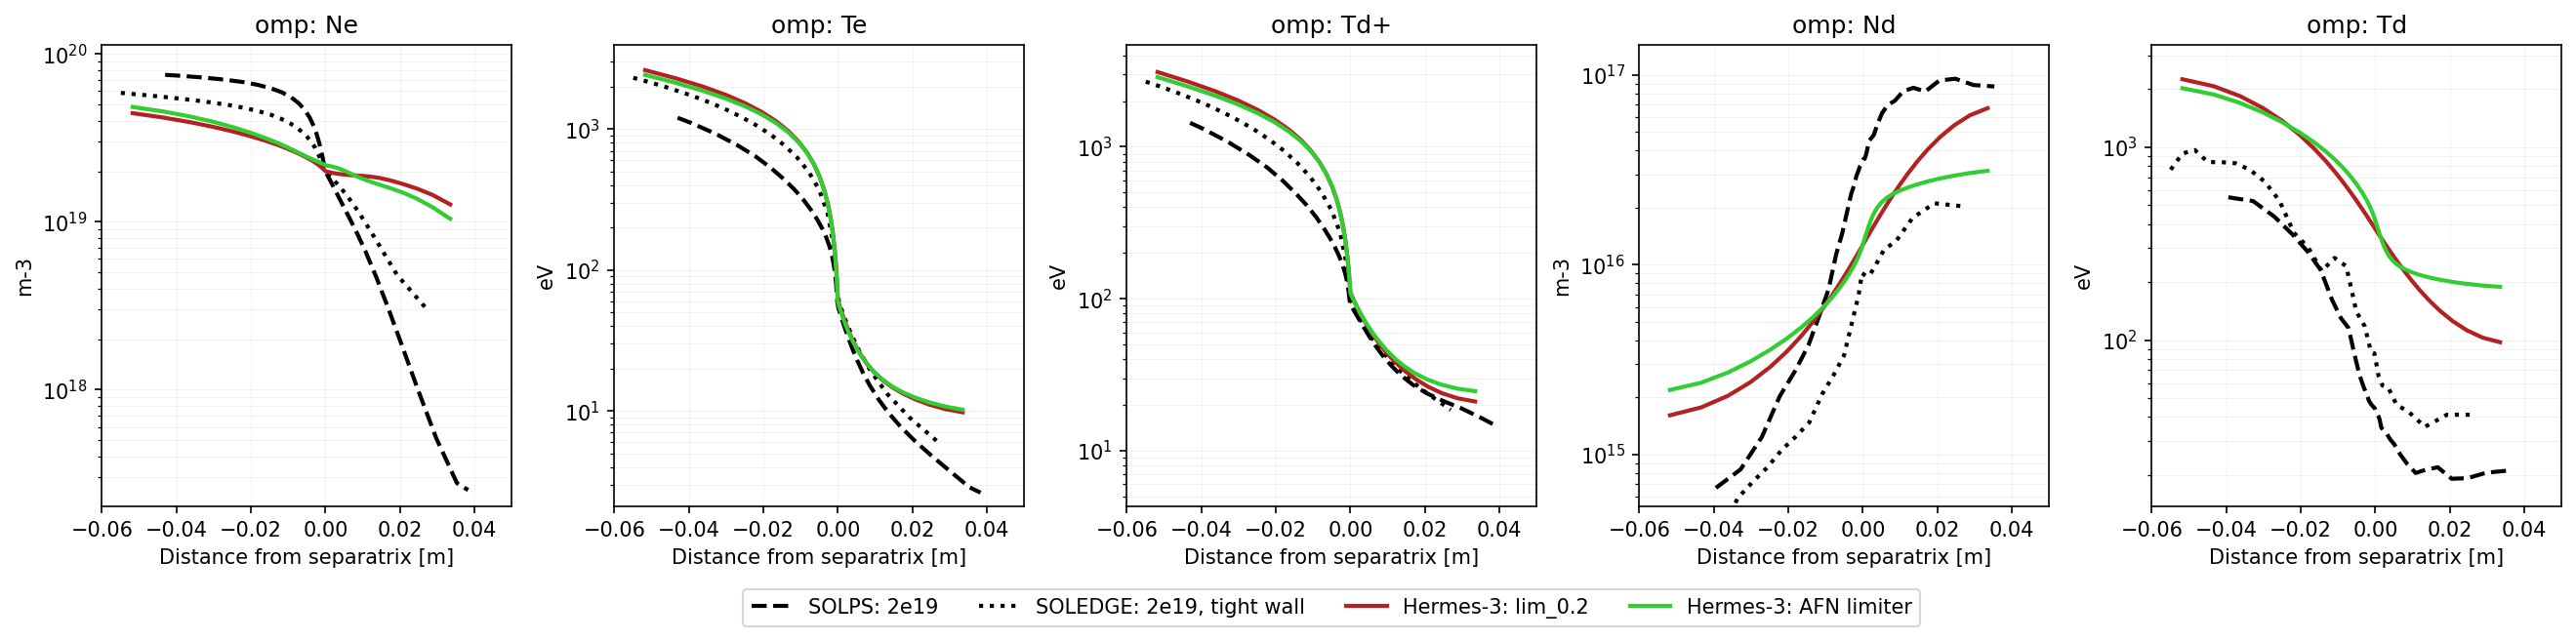

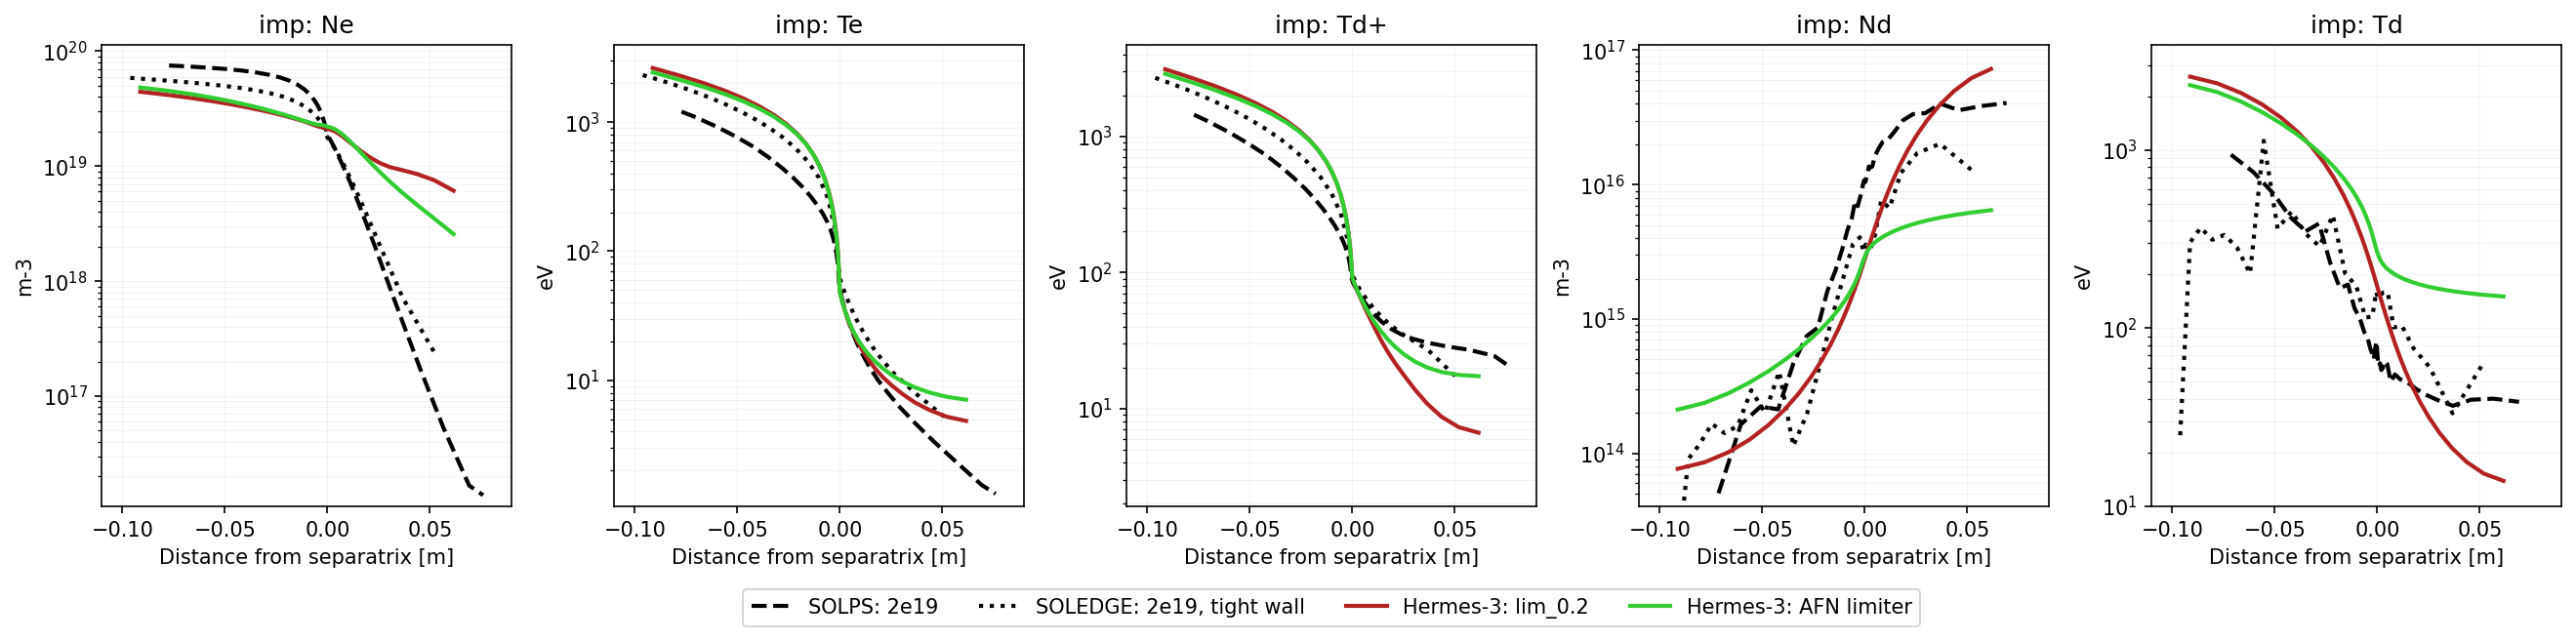

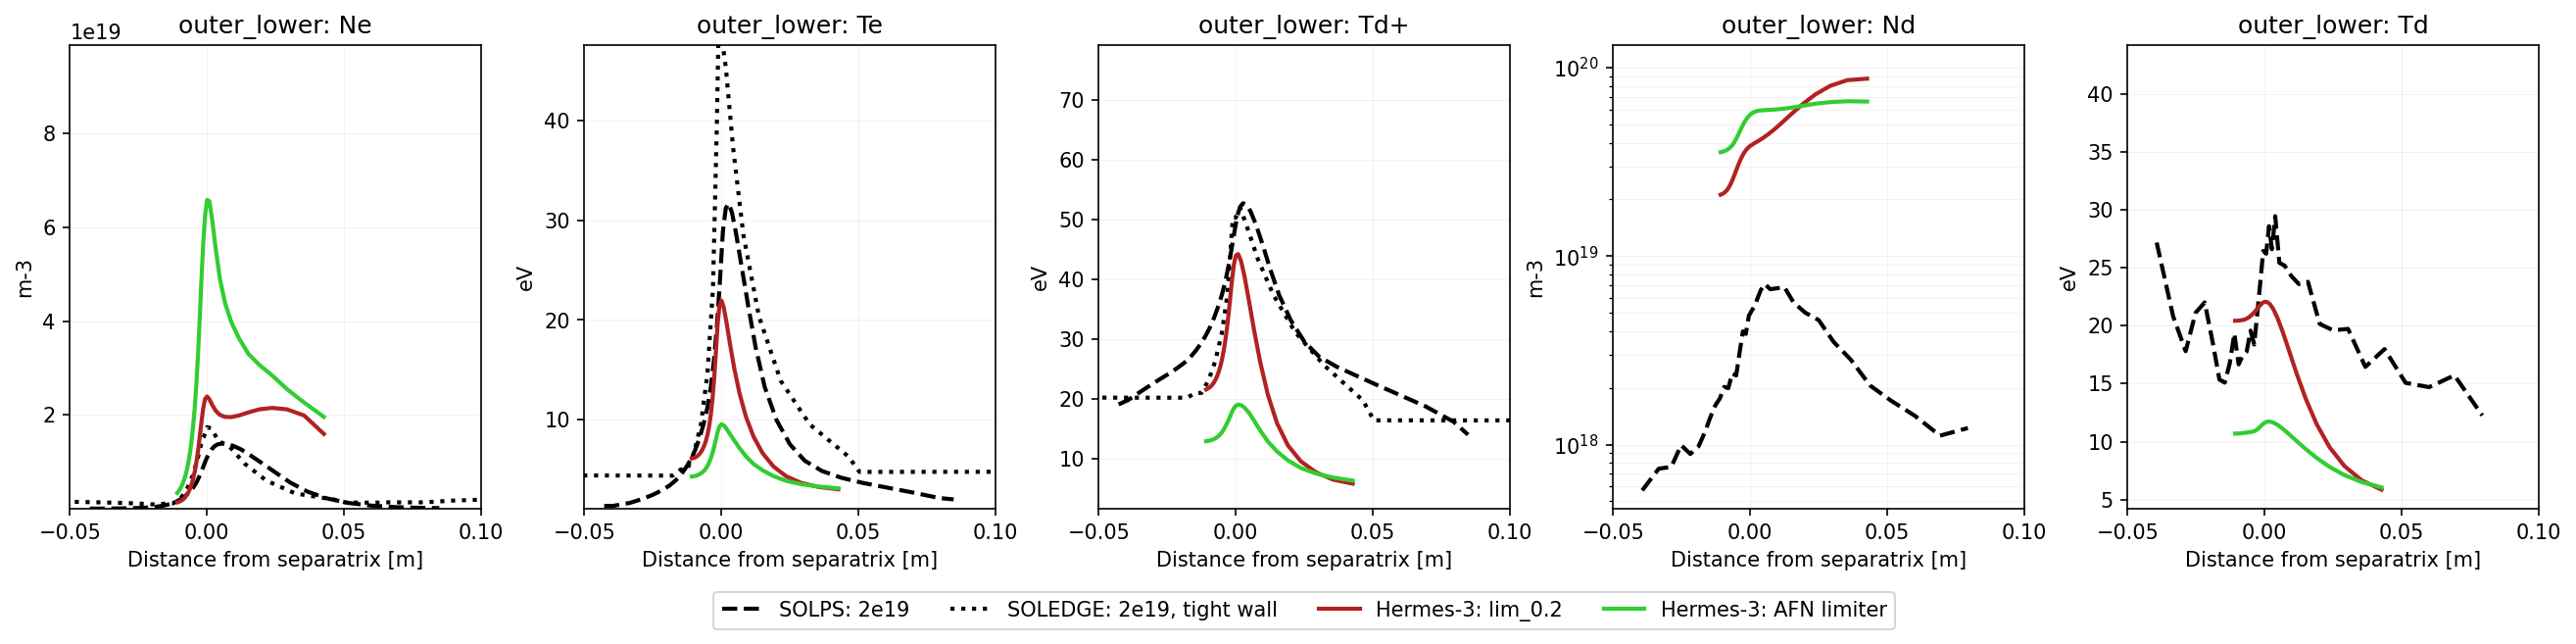

In [10]:

plt.close("all")
lineplot_compare(
    cases = { 
             
    # "SOLPS: 1e19" : dict(data=sp["no_visc"], color="#3288bd"),
    "SOLPS: 2e19" : dict(data=sp["nsep_2e19"], color="black"),
    # "SOLPS: 3e19" : dict(data=sp["nsep_3e19"], color="#fc8d59"),
    
    "SOLEDGE: 2e19, tight wall" : dict(data=sl["tightwall_2e19"], color = "black"),
    
    # "Hermes-3: Neumann": dict(data=hr["2e19"], color="teal"),
    # "Hermes-3: Tn=30": dict(data=hr["fixTn"], color="grey"),
    # "Hermes-3: Tn=Neumann": dict(data=hr["nolim"], color="teal"),
    # "Hermes-3: lim_1.0": dict(data=hr["lim_1.0"], color="darkorange"),
    "Hermes-3: lim_0.2": dict(data=hr["lim_0.2"], color="firebrick"),
    "Hermes-3: AFN limiter": dict(data=hr["isolim"], color="limegreen"),
    # "Hermes-3: Edge recycling": dict(data=hr["2e19_edgerec"], color="cyan"),
    
    
    
    # "Hermes-3: Tn_sol=30eV" : dict(data=hr["tn30"], color="teal"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03_nonsepfit"], color="darkorange"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03"], color="darkorange"),
    
    },
    # regions = ["omp", "imp"], params = ["Ne", "Td+", "Te"],
    # regions = ["omp", "imp"], params = ["Nd", "Td", "Sd+_iz"],
    regions = ["omp", "imp", "outer_lower"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # regions = ["omp", "imp", "outer_lower"], params = ["Nd", "Td"],
    # regions = ["omp"], params = []
    mode = "log",
    dpi = 150,
    lw = 2
)

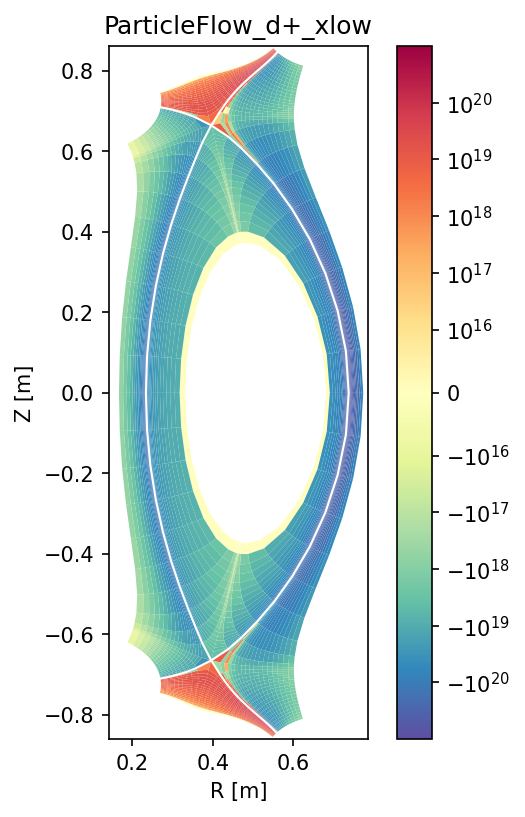

In [10]:
fig, ax = plt.subplots(dpi = 150, figsize = (5,6))

fig.subplots_adjust(wspace=0.4)
ds = casestore["2e19_edgerec"].ds
m = ds.metadata
# hermesm.clean_guards().
(ds["ParticleFlow_d+_xlow"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r", vmin = -1e21, vmax = 1e21, logscale = True)
# (ds["Nd+"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = True)

ax.set_aspect("equal")
# ax.set_ylim(-0.87, 0)

(-0.87, 0.0)

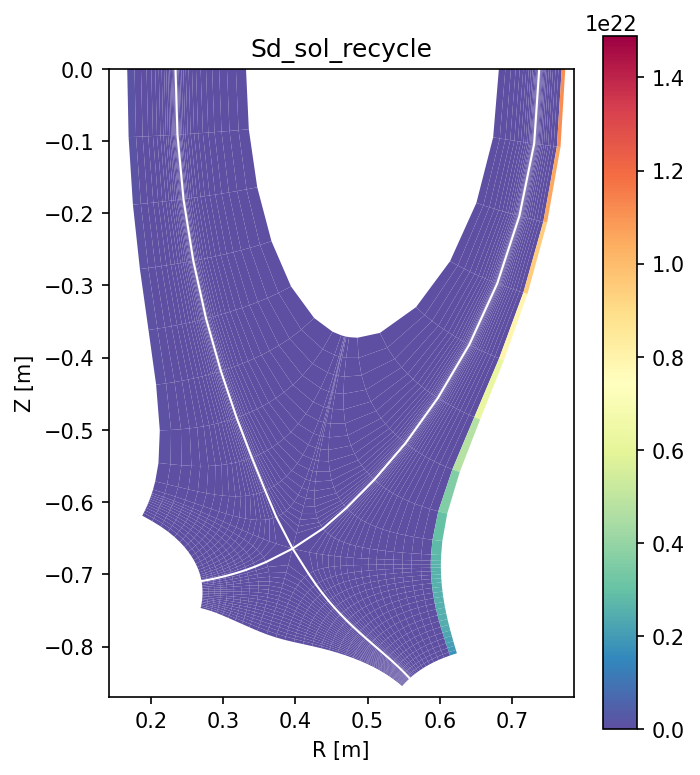

In [12]:
fig, ax = plt.subplots(dpi = 150, figsize = (5,6))

fig.subplots_adjust(wspace=0.4)

m = ds.metadata
# hermesm.clean_guards().
# (ds["ParticleFlow_d+_xlow"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r", vmin = -1e4, vmax = 1e4, logscale = True)
# (ds["Nd+"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = True, vmin = 0.1e18, vmax = 2.5e18)
(ds["Sd_sol_recycle"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = False, vmin = None, vmax = None)

ax.set_aspect("equal")
ax.set_ylim(-0.87, 0)

In [ ]:
dist

array([-0.03952101, -0.03291561, -0.02724013, -0.02241517, -0.01828691,
       -0.0147704 , -0.01181955, -0.00936493, -0.00734814, -0.00569744,
       -0.00436848, -0.00331644, -0.00249648, -0.00186585, -0.00137986,
       -0.00099107, -0.00065423, -0.00032493,  0.        ,  0.00030878,
        0.00062448,  0.00098477,  0.00143339,  0.00201428,  0.00277066,
        0.00374097,  0.00496886,  0.0065018 ,  0.0083827 ,  0.01065512,
        0.01336685,  0.01656384,  0.02028868,  0.02458499,  0.02949914,
        0.03507628])

In [ ]:
self.bal["ne"][:][p[0], :].shape

(0, 112)

In [ ]:
self.s["omp"]

[80, slice(None, None, None)]

In [ ]:
from code_comparison.solps_pp import *
params = ["Ne"]


self = SOLPScase(solpscases["nsep_2e19"])

region = "outer"
dist_from_sep = 0.001

if "outer" in region:
    radial_locator = self.s["omp"]
elif "inner" in region:
    radial_locator = self.s["imp"]
else:
    raise Exception(f"Region {region} not recognised")

p = radial_locator
radial_dist = self.g["R"][p[0], p[1]] - self.g["R"][p[0], self.g["sep"]] 
ring_index = np.argmin(abs(dist_from_sep - radial_dist))
ring_from_sep = ring_index - self.g["sep"]
print(f"Distance {dist_from_sep} corresponds to SOL ring {ring_from_sep}")    

# Get slice of the separatrix for the requested region
p = self.s[region]
p[1] += ring_from_sep   # Advance to desired SOL ring

poloidal_dist = 

dpi = 150
fig, axes = plt.subplots(2,len(params), dpi = dpi, figsize = (4.2*len(params),5), sharex = True)
fig.subplots_adjust(hspace = 0, wspace = 0.25, bottom = 0.25, left = 0.1, right = 0.9)

ax = axes[0]
ax.plot(dist, self.bal["ne"][:][p[0], p[1]])

# Radial flux analysis

In [64]:
def makeflux(ds):
    omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    area_yz = omp["J"] * omp["g11"]
    hflux = omp["pf_perp_diff_R_d"] / area_yz
    return hflux
omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

Text(0, 0.5, 'Radial neutral flux [m-2s-1]')

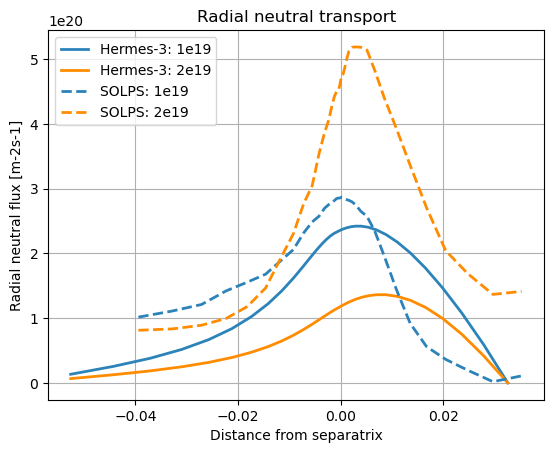

In [60]:
fig, ax = plt.subplots()
ax.plot(dist, -1*(makeflux(casestore["1e19"].ds)), label = "Hermes-3: 1e19", color = "#2b83ba", lw=2)
ax.plot(dist, -1*(makeflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)
ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["rfluxa3da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["rfluxa3da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Radial neutral transport")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("Radial neutral flux [m-2s-1]")

Text(0, 0.5, 'Neutral tempearture [eV]')

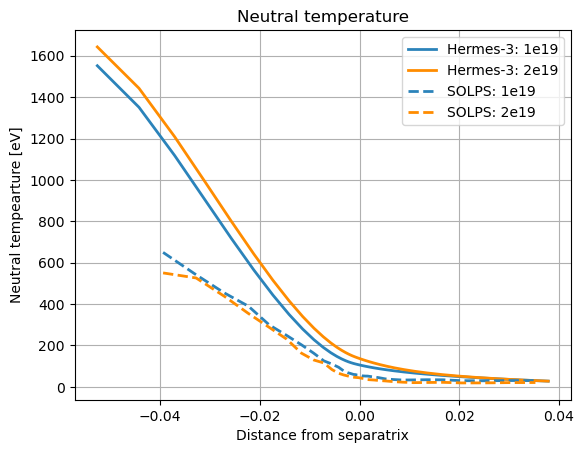

In [72]:
fig, ax = plt.subplots()
colors = ["#2b83ba", "darkorange"]
for i, name in enumerate(["1e19", "2e19"]):
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]
    ax.plot(dist, omp["Td"], label = f"Hermes-3: {name}", color = colors[i], lw=2)
# ax.plot(dist, -1*(makeflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)
ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["tab23da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["tab23da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Neutral temperature")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("Neutral tempearture [eV]")

In [77]:
from sd1d.analysis import AMJUEL

a = AMJUEL()
# rate = a.read_amjuel_2d(path = r"C:\Users\Mike.Kryajak\OneDrive\Project\Atomicrates\H.3 3.1.8.csv")
# cxrate = 

Text(0, 0.5, 'CX rate [s-1m-3]')

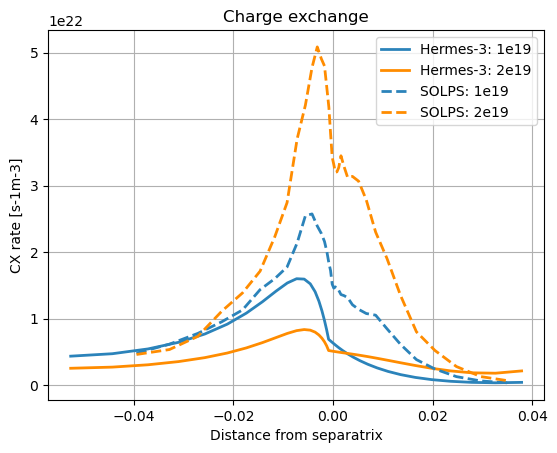

In [89]:
rate = a.amjuel_data["H.2 3.1.8"]
omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

sigmav = [a.amjuel_1d("H.2 3.1.8", t) for t in omp["Te"]]
rate = sigmav * omp["Ne"] * omp["Nd"]

# a.amjuel_1d("H.2 3.1.8", 5)


fig, ax = plt.subplots()
colors = ["#2b83ba", "darkorange"]
for i, name in enumerate(["1e19", "2e19"]):
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]
    
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

    sigmav = [a.amjuel_1d("H.2 3.1.8", T) for T in omp["Te"]]
    rate = sigmav * omp["Ne"] * omp["Nd"]
    ax.plot(dist, rate, label = f"Hermes-3: {name}", color = colors[i], lw=2)

ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["AMJUEL_H.2_3.1.8FJ_3da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["AMJUEL_H.2_3.1.8FJ_3da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Charge exchange")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("CX rate [s-1m-3]")


# Ionisation

In [10]:
plt.close("all")
%matplotlib inline

In [8]:
# rate = a.amjuel_data["H.2 3.1.8"]
# omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
# dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

# sigmav = [a.amjuel_1d("H.2 3.1.8", t) for t in omp["Te"]]
# rate = sigmav * omp["Ne"] * omp["Nd"]

# a.amjuel_1d("H.2 3.1.8", 5)


fig, ax = plt.subplots()
colors = ["#2b83ba", "darkorange"]
for i, name in enumerate(["1e19", "2e19"]):
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]
    
    # omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    # dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

    # sigmav = [a.amjuel_1d("H.2 3.1.8", T) for T in omp["Te"]]
    # rate = sigmav * omp["Ne"] * omp["Nd"]
    ax.plot(dist, omp["Sd+_iz"], label = f"Hermes-3: {name}", color = colors[i], lw=2)

ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["AMJUEL_H.2_3.1.8FJ_3da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["AMJUEL_H.2_3.1.8FJ_3da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Charge exchange")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("CX rate [s-1m-3]")


KeyError: '1e19'

Text(0, 0.5, 'CX rate [s-1m-3]')

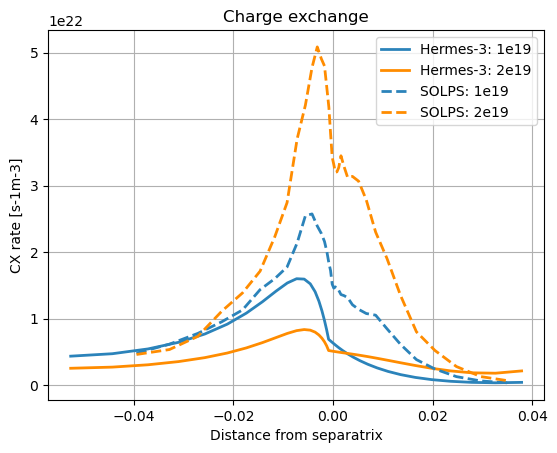

In [ ]:
rate = a.amjuel_data["H.2 3.1.8"]
omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

sigmav = [a.amjuel_1d("H.2 3.1.8", t) for t in omp["Te"]]
rate = sigmav * omp["Ne"] * omp["Nd"]

# a.amjuel_1d("H.2 3.1.8", 5)


fig, ax = plt.subplots()
colors = ["#2b83ba", "darkorange"]
for i, name in enumerate(["1e19", "2e19"]):
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]
    
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

    sigmav = [a.amjuel_1d("H.2 3.1.8", T) for T in omp["Te"]]
    rate = sigmav * omp["Ne"] * omp["Nd"]
    ax.plot(dist, rate, label = f"Hermes-3: {name}", color = colors[i], lw=2)

ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["AMJUEL_H.2_3.1.8FJ_3da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["AMJUEL_H.2_3.1.8FJ_3da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Charge exchange")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("CX rate [s-1m-3]")


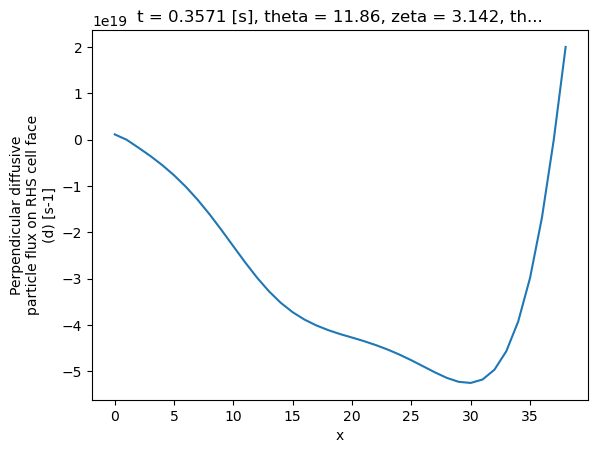

In [26]:
fig, ax = plt.subplots()
colors = ["#2b83ba", "darkorange"]
for i, name in enumerate(["1e19", "2e19"]):
    omp = casestore[name].ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-1))
    dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]
    ax.plot(dist, omp["Td"], label = f"Hermes-3: {name}", color = colors[i], lw=2)
# ax.plot(dist, -1*(makeflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)
# ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["tab23da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
# ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["tab23da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Neutral temperature")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("Neutral tempearture [eV]")

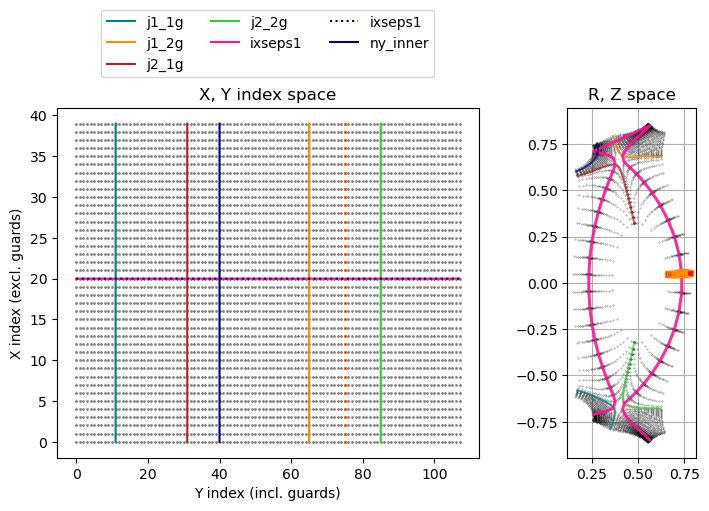

In [24]:
plot_selection(ds, omp)

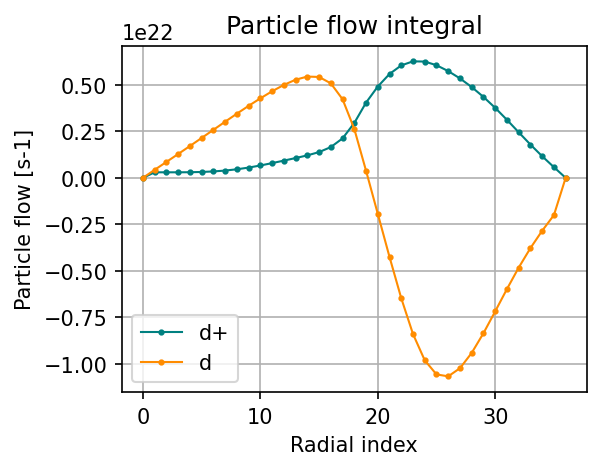

In [16]:
plot_perp_particle_fluxes(ds.isel(t=-1))